#Capstone Project - Sentiment Analysis
##Milestone No. 3
 Machine Learning I: Model selection and hyperparameter tuning

I have thoroughly prepared the data for model selection 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt


#Section 1 
import test and train datasets

In [2]:
#importing data
trainF = pd.read_csv('./Sentiment_Feature_train.csv')
train_Df = trainF
trainL = pd.read_csv('./Sentiment_Label_train.csv')
testF = pd.read_csv('./Sentiment_Feature_test.csv')
test_Df = testF 
testL = pd.read_csv('./Sentiment_Label_test.csv')

In [3]:
train_Df['star_rating'] = trainL['star_rating']
test_Df['star_rating'] = testL['star_rating']

In [4]:
train_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11029 entries, 0 to 11028
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_body  11029 non-null  object
 1   star_rating  11029 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 172.5+ KB


In [5]:
test_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7353 entries, 0 to 7352
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_body  7353 non-null   object
 1   star_rating  7353 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 115.0+ KB


In [6]:
featuresTrain=train_Df['review_body']
labelTrain =train_Df['star_rating']

featuresTest=test_Df['review_body']
labelTest =test_Df['star_rating']

#Section 2 - converting from Panda Data set to Tensor data dset



In [9]:
trainData = (tf.data.Dataset.from_tensor_slices((featuresTrain.values, labelTrain.values))).prefetch(1)
testData = (tf.data.Dataset.from_tensor_slices((featuresTest.values, labelTest.values))).prefetch(1)

In [10]:
trainData, testData

(<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>)

In [11]:
#Testing if my panda dataset became tensor dataset successfully

for featuresTrain, labelTrain in trainData.take(10):
  print('features: {},\t Target: {}\n'.format(featuresTrain.numpy(),labelTrain.numpy()))
 

features: b'Great for price!',	 Target: 1

features: b'Cheap quality and does not fit phone.',	 Target: 0

features: b'Sound quality is pretty good (heavy on the bass). They pinch my ears a bit, so if you have a larger head they might not be for you.',	 Target: 1

features: b'Heavy duty cable that works with my iPhone 5s. Will buy again.',	 Target: 1

features: b'Received product fast and as described',	 Target: 1

features: b'Great fit. But pretty slippery.',	 Target: 1

features: b"Worked great for 4 days. Then it wouldn't charge. Every time I tried to charge it, it would reset and just vibrate. Tried to contact the seller, but the language barrier made it all but impossible. Shipped on time and in good condition.",	 Target: 0

features: b'great Product.no instructions but look it up on YouTube',	 Target: 1

features: b'I was very satisfied with the delivery time and the product.',	 Target: 1

features: b'Like the phone. Still having trouble with downloading photos in messaging.',	 T

##Milestone No. 4
 Machine Learning II: Metrics results and documentation

I have now to understand how RNN works

###Start to prepare for autotuning



In [12]:
# bufferSize is the maximum number of tokens in any text input
bufferSize = 10000

# batchSize is the number of samples to propagate the network
batchSize = 64

# .shuffle() random suffle of data
# .batch() select a batch of samples for the network
# .prefetch() cache data while preceeding data is processed

trainData = trainData.shuffle(buffer_size=bufferSize).batch(batchSize).prefetch(tf.data.AUTOTUNE)
testData = testData.batch(batch_size=batchSize).prefetch(tf.data.AUTOTUNE)

### Text Encoding

![alt text](https://miro.medium.com/max/710/0*gi2oD1gtZvfVaeDC)

In [13]:
# vocabSize is the number of unique of words
vocabSize = 1000

# TextVectorization will convert words to vector of tokens
# For example, go from "Man on the moon" to ["man", "on", "the", "moon"]
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocabSize)

# Use .map() to exclude the label and return only the text from data
tokensOnly = trainData.map(lambda text, label: text)

# .adapt() will apply encoding to tokens only
encoder.adapt(tokensOnly)

In [14]:
encoder

In [15]:
vocab = np.array(encoder.get_vocabulary())

In [16]:
vocab[4:35]

array(['it', 'and', 'a', 'to', 'is', 'my', 'this', 'for', 'of', 'phone',
       'in', 'on', 'with', 'case', 'not', 'great', 'that', 'but', 'was',
       'have', 'you', 'as', 'very', 'so', 'good', 'one', 'product', 'its',
       'works', 'love', 'like'], dtype='<U13')

In [17]:
encodedExample = encoder(featuresTrain)[4:35].numpy()
encodedExample

array([301, 957,  16,   1, 806,  14,   1])

In [18]:
# Build the RNN
# Here, we're using Bidirectional technique, which means
# the data (reviews) will be analyzed left-to-right AND
# right-to-left
modelRNN = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), 
            output_dim=64,
            mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1),
    ]
)

In [19]:
modelRNN.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['accuracy']
)

In [20]:
# I used 6 epochs to attain higher accuracies
metrics = modelRNN.fit(
    trainData,
    epochs=6
)

Epoch 1/6
173/173 [==============================] - 119s 630ms/step - loss: 0.3217 - accuracy: 0.8204
Epoch 2/6
173/173 [==============================] - 110s 635ms/step - loss: 0.1744 - accuracy: 0.9304
Epoch 3/6
173/173 [==============================] - 106s 615ms/step - loss: 0.1503 - accuracy: 0.9415
Epoch 4/6
173/173 [==============================] - 107s 619ms/step - loss: 0.1298 - accuracy: 0.9525
Epoch 5/6
173/173 [==============================] - 105s 606ms/step - loss: 0.1066 - accuracy: 0.9598
Epoch 6/6
173/173 [==============================] - 109s 630ms/step - loss: 0.0868 - accuracy: 0.9695


In [ ]:
#plotting the accuracy and loss 
#per last run, I was able to attain 96% accuracy and loss of 8.68%

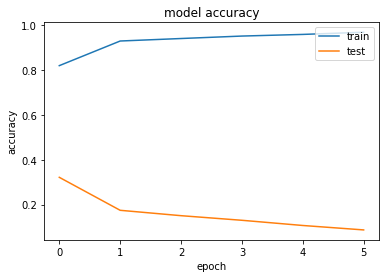

In [130]:
plt.plot(metrics.history['accuracy'])
plt.plot(metrics.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [22]:
# Check metrics after test (evaluate)
testLoss, testAccuracy = modelRNN.evaluate(testData)

print('Loss: ', testLoss)
print('Accuracy: ', testAccuracy)

115/115 [==============================] - 22s 173ms/step - loss: 0.2770 - accuracy: 0.8965
Loss:  0.2770177125930786
Accuracy:  0.896504819393158


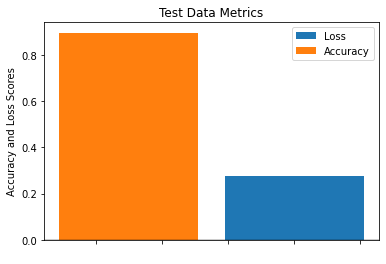

In [129]:
# Visualize the metrics
fig, ax = plt.subplots()

p1 = ax.bar(0.5, testLoss, 0.21, bottom=None, label='Loss')
p2 = ax.bar(0.25, testAccuracy, 0.21, bottom=None, label='Accuracy')

ax.axhline(0, color='black', linewidth=0.4)
ax.set_ylabel('Accuracy and Loss Scores')
ax.set_title('Test Data Metrics')
ax.set_xticklabels((' ',  ' '))
ax.legend()

plt.show()

In [24]:
# Predict a review
sampleMovieReview = [
    'What a great movie!! Would definitely watch again',
    'Trash movie. Who even approved this thing? Terrible acting, terrible directing.'
]

predictions = modelRNN.predict( np.array(sampleMovieReview) )

In [132]:
print(predictions)

[[ 4.9881835]
 [-6.632091 ]]
